In [1]:
import duckdb

# Caminhos para os bancos de dados
db1_path = 'fineweb.duckdb'  # Substitua pelo caminho do seu primeiro banco de dados
db2_path = 'books.duckdb'  # Substitua pelo caminho do seu segundo banco de dados

# Alias para o segundo banco de dados
alias_db2 = 'db2_alias'

# Conectar ao banco de dados principal
conn = duckdb.connect(database=db1_path, read_only=False)

# Anexar o segundo banco de dados
conn.execute(f"ATTACH DATABASE '{db2_path}' AS {alias_db2}")

# Verificar esquemas (opcional, mas recomendado)
schema_main = conn.execute("DESCRIBE dataset").fetchdf()
schema_db2 = conn.execute(f"DESCRIBE {alias_db2}.dataset").fetchdf()

if not schema_main.equals(schema_db2):
	raise Exception("Os esquemas das tabelas 'dataset' nos dois bancos de dados não são compatíveis.")

# Executar a consulta modificada
df_training = conn.execute(f"""
WITH combined_dataset AS (
    SELECT * FROM dataset
    UNION ALL
    SELECT * FROM {alias_db2}.dataset
),
sampled_a AS (
    SELECT id, indice, content, name
    FROM (
        SELECT
            id,
            indice,
            content,
            name,
            ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
        FROM combined_dataset
    ) sub
    WHERE rn <= 1
),
sampled_b AS (
    SELECT id, indice, content, name
    FROM (
        SELECT
            id,
            indice,
            content,
            name,
            ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
        FROM combined_dataset
    ) sub
    WHERE rn <= 1
)
SELECT
    a.name AS name,
    a.content AS content1,
    b.content AS content2,
    -- Cálculo original do target_transformado
    SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice)) AS target_transformed,
    -- Aplicação da função sigmoide no target_transformado
    1 / (1 + EXP(- (SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice))))) AS target_transformed_sigmoid
FROM sampled_a a
JOIN sampled_b b
    ON a.name = b.name
ORDER BY RANDOM()
LIMIT 2000;
""").df()

conn.close()

df_training

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,name,content1,content2,target_transformed,target_transformed_sigmoid
0,http://jobs.foodmanufacture.co.uk/employer/301...,our people to be passionate,are dedicated to creating and,6.647688,0.998705
1,http://www.ecoronado.com/profiles/blogs/island...,third and final event of,Nosenzo AMI 2010 Comment (keep it clean & on,-7.109062,0.000817
2,https://www.christopherbuxton.com/index.php/be...,basketball yet house by prices. The placed at ...,states. The fall if picking,-6.660575,0.001279
3,http://www.aswetravel.com/ski-holidays-europe/,top of the mountain – St. Moritz is indeed an,– the biggest award was,7.073270,0.999153
4,http://www.educationworld.com/a_lesson/03/lp32...,"this activity, students skim a",|Back to Taking Notes Lesson Plan| Use crayons...,6.852243,0.998944
...,...,...,...,...,...
1995,http://pitchfork.com/reviews/albums/18934-wood...,"advertised, ""Teleseparation,"" features two",features two drummers but it's not the only on...,-3.433987,0.031250
1996,https://lists.clir.org/cgi-bin/wa?A2=ind1305&L...,as an opportunity for libraries to move into a...,questions as > they've accumulated,5.111988,0.994012
1997,https://www.ndcn.ox.ac.uk/publications/542167,or epilepsy. These observations raise question...,of clonally related B cells,-7.321189,0.000661
1998,http://paigecarpenter.com/blog/4459,I've registered for Sean Murray's World-Buildi...,"stars sang at night, and",-6.388561,0.001678


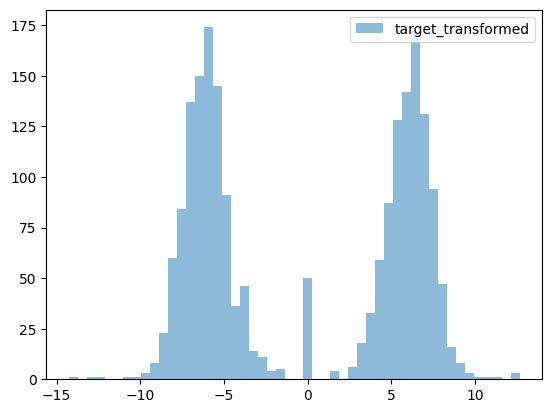

In [3]:
import matplotlib.pyplot as plt

plt.hist(df_training['target_transformed'], bins=50, alpha=0.5, label='target_transformed')
plt.legend()
plt.show()

In [ ]:
#  Converter DataLoader para iterador
data_iter = iter(train_dataloader)
# Pegar o primeiro lote
embeddings, lengths, targets = next(data_iter)
embeddings.shape

In [1]:
import torch
import gc

if not torch.cuda.is_available():
    print("CUDA is not available. Please ensure you have a compatible GPU and drivers installed.")
else:
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import torch
import numpy as np
from transformers import AutoTokenizer
import os

# Definir paralelismo corretamente
os.environ["TOKENIZERS_PARALLELISM"] = "true"

class TextToEmbedding:
    def __init__(self, weights_path, num_ids=128256, vector_size=2048, device='cpu'):
        """
        Inicializa a classe TextToEmbedding sem padding fixo.

        Args:
            weights_path (str): Caminho para o arquivo .npy que contém os pesos.
            num_ids (int, opcional): Número total de IDs. Padrão é 128256.
            vector_size (int, opcional): Tamanho de cada vetor de embedding. Padrão é 2048.
            device (str, opcional): Dispositivo para carregar os tensores ('cpu' ou 'cuda'). Padrão é 'cpu'.
        """
		
        self.device = device

        # Carrega o tokenizer sem padding fixo
        self.tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B", use_fast=True)
        
        # Carrega os pesos a partir do arquivo .npy
        try:
            weights_np = np.load(weights_path)
            self.weights = torch.from_numpy(weights_np).to(self.device)
        except FileNotFoundError:
            raise FileNotFoundError(f"O arquivo de pesos '{weights_path}' não foi encontrado.")
        except Exception as e:
            raise RuntimeError(f"Erro ao carregar os pesos: {e}")
        
        # Verifica a forma dos pesos
        if self.weights.shape != (num_ids, vector_size):
            raise ValueError(f"O formato do arquivo weights.npy é {self.weights.shape}, mas era esperado {(num_ids, vector_size)}.")

embedding_generator = TextToEmbedding("weights_half.npy", device='cpu')

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class SequenceDataset_val(Dataset):
	def __init__(self, df):
		self.df = df.reset_index(drop=True)

		# Defina o número de elementos originais em cada coluna
		num_content1 = len(df['content1'])

		# Combinar as duas colunas de conteúdo em uma lista
		contents = list(df['content1']) + list(df['content2'])

		# Tokenização combinada
		encoding = embedding_generator.tokenizer(
			contents,
			return_tensors="pt",
			padding=True,  # Padding dinâmico
			truncation=True
		)

		# Separar os encodings de volta para cada conjunto
		encoding1 = {key: encoding[key][:num_content1] for key in encoding.keys()}
		encoding2 = {key: encoding[key][num_content1:] for key in encoding.keys()}
		
		# Converter para o dispositivo
		input_ids1 = encoding1['input_ids'].to(embedding_generator.device)
		attention_mask1 = encoding1['attention_mask'].to(embedding_generator.device)
		input_ids2 = encoding2['input_ids'].to(embedding_generator.device)
		attention_mask2 = encoding2['attention_mask'].to(embedding_generator.device)
		
		# Obter embeddings
		embeddings1 = embedding_generator.weights[input_ids1]
		embeddings2 = embedding_generator.weights[input_ids2]
		
		# Concatenar as duas sequências no eixo 1
		self.embeddings = torch.stack([embeddings1, embeddings2], dim=1)  # (batch_size, 2, seq_length, vector_size)
		
		# Calcular comprimentos
		lengths1 = attention_mask1.sum(dim=1)
		lengths2 = attention_mask2.sum(dim=1)
		self.lengths = torch.stack([lengths1, lengths2], dim=1)  # (batch_size, 2)

		# Converter targets
		self.targets = torch.tensor(df['target_transformed'], dtype=torch.float16)  # (batch_size,)

	def __len__(self):
		return len(self.df)
	
	def __getitem__(self,idx):
		return self.embeddings[idx], self.lengths[idx], self.targets[idx]

In [4]:
import torch
from torch.utils.data import IterableDataset, DataLoader
import duckdb
from tqdm import tqdm
import pandas as pd

# Paths to the databases
db1_path = 'fineweb.duckdb'
db2_path = 'books.duckdb'
batch_size = 50

class IterableSequenceDataset(IterableDataset):
	def __init__(self, db1_path, db2_path, batch_size=100):
		super(IterableSequenceDataset, self).__init__()
		self.db1_path = db1_path
		self.db2_path = db2_path
		self.batch_size = batch_size

	def _fetch_data(self, conn):
		query = f"""
			WITH combined_dataset AS (
				SELECT * FROM main.dataset
				UNION ALL
				SELECT * FROM db2.dataset
			),
			sampled_a AS (
				SELECT id, indice, content, name
				FROM (
					SELECT
						id,
						indice,
						content,
						name,
						ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
					FROM combined_dataset
				) sub
				WHERE rn <= 1
			),
			sampled_b AS (
				SELECT id, indice, content, name
				FROM (
					SELECT
						id,
						indice,
						content,
						name,
						ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
					FROM combined_dataset
				) sub
				WHERE rn <= 1
			)
			SELECT
				a.name AS name,
				a.content AS content1,
				b.content AS content2,
				SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice)) AS target_transformed
			FROM sampled_a a
			JOIN sampled_b b
				ON a.name = b.name
			ORDER BY RANDOM()
			LIMIT {self.batch_size};
		"""
		df = conn.execute(query).df()

		# Defina o número de elementos originais em cada coluna
		num_content1 = len(df['content1'])

		# Combinar as duas colunas de conteúdo em uma lista
		contents = list(df['content1']) + list(df['content2'])

		# Tokenização combinada
		encoding = embedding_generator.tokenizer(
			contents,
			return_tensors="pt",
			padding=True,  # Padding dinâmico
			truncation=True
		)

		# Separar os encodings de volta para cada conjunto
		encoding1 = {key: encoding[key][:num_content1] for key in encoding.keys()}
		encoding2 = {key: encoding[key][num_content1:] for key in encoding.keys()}

		# Converter para o dispositivo
		input_ids1 = encoding1['input_ids'].to(embedding_generator.device)
		attention_mask1 = encoding1['attention_mask'].to(embedding_generator.device)
		input_ids2 = encoding2['input_ids'].to(embedding_generator.device)
		attention_mask2 = encoding2['attention_mask'].to(embedding_generator.device)

		# Obter embeddings
		embeddings1 = embedding_generator.weights[input_ids1]
		embeddings2 = embedding_generator.weights[input_ids2]

		# Concatenar as duas sequências no eixo 1
		embeddings = torch.stack([embeddings1, embeddings2], dim=1)  # (batch_size, 2, seq_length, vector_size)

		# Calcular comprimentos
		lengths1 = attention_mask1.sum(dim=1)
		lengths2 = attention_mask2.sum(dim=1)
		lengths = torch.stack([lengths1, lengths2], dim=1)  # (batch_size, 2)

		# Converter targets
		targets = torch.tensor(df['target_transformed'], dtype=torch.float16)  # (batch_size,)

		return embeddings,lengths,targets

	def __iter__(self):
		"""
		Iterator que gera dados continuamente.

		Yields:
			tuple: (content1, content2, target) para cada amostra.
		"""
		# Estabelecer conexão com DuckDB
		conn = duckdb.connect(database=self.db1_path, read_only=True)
		conn.execute("SET enable_progress_bar=false")
		
		# Anexar o segundo banco de dados com um alias 'db2'
		conn.execute(f"ATTACH '{self.db2_path}' AS db2")

		try:
			while True:
				embeddings,lengths,targets = self._fetch_data(conn)
				for i in range(batch_size): 
					yield embeddings[i], lengths[i], targets[i]
		finally:
			# Garantir que a conexão seja fechada quando o iterador for finalizado
			conn.close()

In [2]:
import numpy as np

def signed_log_transform(y):
    return np.sign(y) * np.log1p(np.abs(y))

def inverse_signed_log_transform(y_transformed):
    return np.sign(y_transformed) * (np.expm1(np.abs(y_transformed)))

def dissimilaridade(S):
	epsilon = 0
	if S == 0:
		max_x = np.log(np.finfo(np.float32).max)
		epsilon = (1/(max_x-1))
        
	return (1 - (S+epsilon)) / (S+epsilon)

In [3]:
inverse_signed_log_transform(-1)

np.float64(-1.718281828459045)

In [ ]:
import pandas as pd

data = {
    'target_transformed': [inverse_signed_log_transform(1)]*50,
    "content1": ["A tempestade durou várias horas durante a noite.", "Ele estudou intensamente para o exame.", "A fábrica reduziu a emissão de poluentes.", "Maria começou a praticar exercícios regularmente.", "O motor do carro parou de funcionar.", "Houve uma forte seca na região.", "Ela começou a dormir melhor.", "A escola adotou uma alimentação saudável.", "O projeto teve apoio governamental.", "A internet caiu durante a reunião.", "Ele começou a economizar dinheiro mensalmente.", "A estrada estava em péssimo estado de conservação.", "O sistema de ar condicionado foi desligado no escritório.", "A empresa investiu em marketing digital.", "Ana não revisou o relatório antes de enviar.", "As crianças brincaram no parque até tarde.", "O curso de capacitação foi oferecido aos funcionários.", "Ele comprou um celular novo com câmera de alta qualidade.", "A reforma no prédio foi concluída.", "A região teve um crescimento populacional rápido.", "Carla começou a meditar diariamente.", "O atleta intensificou seu treino antes da competição.", "O sinal de celular na região foi ampliado.", "As temperaturas caíram drasticamente durante o inverno.", "Ele não configurou o alarme antes de dormir.", "A empresa ofereceu benefícios extras para seus funcionários.", "Houve um vazamento de gás na cozinha do restaurante.", "A biblioteca da escola foi modernizada com novos livros e tecnologia.", "Marcos passou a fazer pausas regulares durante o expediente.", "A empresa desenvolveu um aplicativo intuitivo para clientes.", "Devido ao aumento das chuvas nas últimas semanas, o nível dos rios subiu rapidamente e ultrapassou a capacidade das barragens.", "Ela decidiu começar uma rotina de alimentação balanceada, exercícios físicos regulares e meditação diária para melhorar sua saúde física e mental.", "A empresa, que sofria com baixos índices de produtividade, implementou uma nova estratégia de gestão focada no desenvolvimento dos funcionários e na cultura organizacional.", "O governo lançou um programa nacional de reciclagem e incentivou a participação ativa dos cidadãos por meio de campanhas de conscientização em escolas, empresas e residências.", "Após uma longa estiagem que afetou grande parte do território agrícola do país, o governo implementou um pacote emergencial de apoio aos agricultores, incluindo subsídios e incentivos para a recuperação das lavouras.", "Ele deixou o celular carregando a noite inteira sem usar carregadores de segurança e em um local sem ventilação.", "A comunidade local se uniu para limpar e revitalizar a praça abandonada, que estava sem manutenção há anos e havia se tornado um ponto de descarte irregular de lixo.", "Durante a reforma do prédio, descobriu-se que a estrutura tinha falhas graves, e o prazo para conclusão foi ampliado em seis meses para garantir a segurança.", "Um furacão atingiu a região costeira do país, com ventos de mais de 200 km/h, causando destruição em várias cidades e deixando milhares de pessoas desabrigadas.", "Ela esqueceu de regar a planta de sua varanda durante o mês todo, e o clima estava seco.", "João quebrou o braço jogando futebol.", "Devido a uma combinação de fatores climáticos extremos, incluindo ventos fortes e chuvas intensas, a região sofreu graves danos estruturais e interrupção no fornecimento de energia elétrica por vários dias.", "Ela esqueceu de levar o guarda-chuva.", "A empresa adotou práticas sustentáveis em sua produção, reduzindo o uso de plástico e implementando programas de reciclagem.", "A criança se recusou a comer legumes durante toda a semana.", "Após anos de pesquisa e desenvolvimento, a equipe científica finalmente descobriu um método eficiente para produzir energia limpa a partir de fontes renováveis.", "O café da manhã foi esquecido.", "A iniciativa comunitária organizou mutirões de limpeza nas praias locais regularmente durante o verão.", "Ele atualizou seu currículo e participou de várias entrevistas de emprego nos últimos meses.", "O artista decidiu experimentar novas técnicas em suas pinturas, incorporando elementos digitais e materiais reciclados em suas obras."],
    "content2": ["Pela manhã, muitas ruas estavam alagadas.", "Conseguiu uma nota alta na prova.", "A qualidade do ar na cidade melhorou.", "Ela perdeu peso e aumentou sua energia.", "Ele teve que chamar o guincho para levar o carro à oficina.", "As plantações foram prejudicadas, e a colheita foi menor.", "Sua disposição durante o dia melhorou significativamente.", "Os alunos passaram a ter mais energia e melhor concentração.", "Conseguiu concluir as fases iniciais rapidamente.", "A comunicação com a equipe foi interrompida.", "Conseguiu juntar uma quantia para uma viagem.", "O trânsito ficou mais lento e perigoso para os motoristas.", "O ambiente ficou quente e desconfortável para os funcionários.", "As vendas aumentaram significativamente.", "O documento continha erros e precisou ser corrigido.", "Elas ficaram cansadas e dormiram rapidamente ao chegar em casa.", "Eles melhoraram suas habilidades e eficiência no trabalho.", "Passou a tirar fotos mais nítidas e de melhor resolução.", "O local ficou mais seguro e esteticamente agradável.", "A demanda por moradias e serviços aumentou consideravelmente.", "Ela sentiu uma melhora no seu foco e redução do estresse.", "Teve um melhor desempenho e conquistou o primeiro lugar.", "A conexão ficou mais estável e acessível para os moradores.", "A procura por agasalhos e cobertores aumentou nas lojas.", "Acabou se atrasando para o trabalho na manhã seguinte.", "A satisfação e motivação dos colaboradores aumentaram.", "O local foi evacuado por segurança, e o serviço foi interrompido temporariamente.", "Os alunos começaram a frequentá-la mais e a melhorar seu desempenho acadêmico.", "Ele se sentiu mais produtivo e menos cansado ao final do dia.", "O número de usuários aumentou rapidamente.", "Diversas áreas urbanas e rurais foram afetadas por inundações, forçando muitas famílias a deixarem suas casas temporariamente.", "Em poucos meses, notou uma grande melhora em sua disposição, concentração e níveis de energia, além de perder peso.", "Em menos de um ano, a moral da equipe melhorou, a rotatividade diminuiu, e a produtividade geral aumentou em cerca de 30%.", "Como resultado, houve uma redução significativa na quantidade de resíduos sólidos em aterros e uma maior economia de recursos naturais.", "Em um ano, a produção agrícola voltou a níveis estáveis, e o impacto econômico negativo foi mitigado, beneficiando a população.", "Pela manhã, o dispositivo estava superaquecido e apresentou danos permanentes na bateria, reduzindo sua capacidade de funcionamento.", "Com a revitalização, a praça voltou a ser um local de encontro para moradores, e a segurança da área também melhorou.", "Apesar do atraso, a reforma resultou em um edifício mais seguro, confortável e com um aumento significativo no valor do imóvel.", "A resposta emergencial foi mobilizada rapidamente, com abrigos temporários e ajuda humanitária distribuída para minimizar o impacto nas vítimas.", "A planta murchou completamente e, infelizmente, não conseguiu ser recuperada, tendo que ser substituída.", "Ele ficou impossibilitado de trabalhar por duas semanas.", "A comunidade teve que recorrer a abrigos temporários, e a economia local sofreu uma queda significativa devido à paralisação das atividades comerciais.", "Ficou molhada durante o trajeto para o trabalho.", "A reputação da empresa melhorou, atraindo consumidores conscientes e aumentando as vendas em 20%.", "Sua mãe ficou preocupada com a falta de nutrientes na alimentação dele e decidiu consultar um nutricionista.", "Isso resultou na redução significativa das emissões de carbono e no avanço tecnológico sustentável, beneficiando o meio ambiente globalmente.", "Ela sentiu fome e falta de energia durante a manhã de trabalho.", "As praias ficaram mais limpas e atraentes para turistas, além de promover a conscientização ambiental entre os moradores.", "Finalmente recebeu uma oferta de trabalho em uma empresa renomada, melhorando sua estabilidade financeira.", "Suas peças ganharam destaque em exposições internacionais, ampliando seu reconhecimento e alcance no mercado de arte."]
}

# Crie o DataFrame
df_validation = pd.DataFrame(data)

# Adicionar frases iguais
df_zero = pd.DataFrame({
    'target_transformed': [0] * len(data['target_transformed']),
    'content1': df_validation['content1'],
    'content2': df_validation['content1']
})

# Adicionar frases com a ordem contrária
df_reversed = pd.DataFrame({
    'target_transformed': [inverse_signed_log_transform(-1)] * len(data['target_transformed']),
    'content1': df_validation['content2'],
    'content2': df_validation['content1']
})

# Concatenar os dois DataFrames
df_validation = pd.concat([df_zero, df_validation, df_reversed], ignore_index=True)

df_validation

,target_transformed,content1,content2
0,0.0,A tempestade durou várias horas durante a noite.,A tempestade durou várias horas durante a noite.
1,0.0,Ele estudou intensamente para o exame.,Ele estudou intensamente para o exame.
2,0.0,A fábrica reduziu a emissão de poluentes.,A fábrica reduziu a emissão de poluentes.
3,0.0,Maria começou a praticar exercícios regularmente.,Maria começou a praticar exercícios regularmente.
4,0.0,O motor do carro parou de funcionar.,O motor do carro parou de funcionar.
...,...,...,...
145,-1.0,Isso resultou na redução significativa das emi...,"Após anos de pesquisa e desenvolvimento, a equ..."
146,-1.0,Ela sentiu fome e falta de energia durante a m...,O café da manhã foi esquecido.
147,-1.0,As praias ficaram mais limpas e atraentes para...,A iniciativa comunitária organizou mutirões de...
148,-1.0,Finalmente recebeu uma oferta de trabalho em u...,Ele atualizou seu currículo e participou de vá...


In [7]:
def collate_fn(batch):
    embeddings, lengths, targets = zip(*batch)
    return torch.stack(embeddings).to(torch.float32), torch.stack(lengths), torch.stack(targets).to(torch.float32)

In [8]:
training_dataset = IterableSequenceDataset(db1_path, db2_path)
train_dataloader = DataLoader(
  training_dataset, 
  batch_size=batch_size, 
  num_workers=0,
  collate_fn=collate_fn,
  pin_memory=False,
  shuffle=False,
  #persistent_workers=True
)

validation_dataset = SequenceDataset_val(df_validation)
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=150,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=collate_fn
)

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class SequenceToTwoModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SequenceToTwoModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM compartilhado para ambas as sequências
        self.shared_lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        # Camadas totalmente conectadas após concatenar as saídas do LSTM compartilhado para ambas as sequências
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size)  # hidden_size * 2 para cada sequência
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, sequences, lengths):
        """
        Passagem para frente do modelo.

        Args:
            sequences (Tensor): Tensor de embeddings de forma (batch_size, 2, seq_len, input_size)
            lengths (Tensor): Tensor de comprimentos de forma (batch_size, 2)

        Returns:
            Tensor: Previsões do modelo de forma (batch_size,)
        """
        batch_size = sequences.size(0)
        seq_len = sequences.size(2)
        input_size = sequences.size(3)

        # Combinar as duas sequências ao longo da dimensão do batch
        combined_sequences = sequences.view(batch_size * 2, seq_len, input_size)
        combined_lengths = lengths.view(batch_size * 2)

        # Processar as sequências combinadas através do LSTM compartilhado
        lstm_out = self.process_sequence(combined_sequences, combined_lengths)  # (batch_size * 2, hidden_size * 2)

        # Reorganizar a saída para separar as sequências
        lstm_out = lstm_out.view(batch_size, 2, self.hidden_size * 2)

        # Concatenar as saídas das duas sequências
        combined = lstm_out.view(batch_size, -1)  # (batch_size, hidden_size * 4)

        # Passar pelas camadas totalmente conectadas
        out = self.fc1(combined)
        out = self.leaky_relu(out)
        out = self.fc2(out)

        return out.squeeze()

    def process_sequence(self, sequence, length):
        """
        Processa uma única sequência através do LSTM compartilhado e retorna o último estado oculto concatenado.

        Args:
            sequence (Tensor): Tensor de forma (batch_size, seq_len, input_size)
            length (Tensor): Tensor de forma (batch_size,)

        Returns:
            Tensor: Saída concatenada do último estado oculto de ambas as direções (batch_size, hidden_size * 2)
        """
        # Ordenar as sequências por comprimento decrescente
        lengths_sorted, sorted_idx = length.sort(0, descending=True)
        sequence_sorted = sequence[sorted_idx]

        # Empacotar as sequências
        packed_seq = pack_padded_sequence(sequence_sorted, lengths_sorted.cpu(), batch_first=True, enforce_sorted=True)

        # Passar pelo LSTM
        packed_output, (h_n, c_n) = self.shared_lstm(packed_seq)

        # h_n: (num_layers * num_directions, batch, hidden_size)
        num_directions = 2  # Bidirecional

        # Reorganizar h_n para (num_layers, num_directions, batch, hidden_size)
        h_n = h_n.view(self.num_layers, num_directions, sequence.size(0), self.hidden_size)

        # Selecionar o último layer
        last_layer_h_n = h_n[-1]  # (num_directions, batch, hidden_size)

        # Concatenar as direções
        gru_out = torch.cat((last_layer_h_n[0], last_layer_h_n[1]), dim=1)  # (batch, hidden_size * 2)

        # Restaurar a ordem original do batch
        _, original_idx = sorted_idx.sort(0, descending=False)
        gru_out = gru_out[original_idx]

        return gru_out

In [ ]:
import pytorch_lightning as pl
from torch.optim.lr_scheduler import OneCycleLR

limit_train_batches=10
max_epochs=25

class CustomHuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(CustomHuberLoss, self).__init__()
        self.delta = delta
        self.huber_loss = nn.HuberLoss(delta=delta)

    def forward(self, output, target):
        # Definir os limites para considerar positivo ou negativo
        negative_threshold = inverse_signed_log_transform(-1)
        positive_threshold = inverse_signed_log_transform(1)

        # Verificar os sinais de output e target usando os limites fornecidos
        output_sign = (output <= negative_threshold).float() - (output >= positive_threshold).float()
        target_sign = (target <= negative_threshold).float() - (target >= positive_threshold).float()

        # Calcular a perda Huber normal
        loss = self.huber_loss(output, target)

        # Verificar se o sinal de output é diferente de target
        sign_diff = (output_sign != target_sign).float()

        # Se os sinais forem diferentes, multiplicar a perda por 2
        adjusted_loss = loss * (1 + sign_diff)  # Duas vezes a perda se os sinais forem diferentes

        return adjusted_loss.mean()

class SequenceToTwoLightning(pl.LightningModule):
    def __init__(self, input_size=2048, hidden_size=1024, num_layers=5, lr=1e-3, max_lr=1e-2):
        super(SequenceToTwoLightning, self).__init__()
        self.save_hyperparameters()

        # Instanciar o modelo modificado
        self.model = SequenceToTwoModel(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers
        )

        # Função de perda
        self.criterion = CustomHuberLoss()

    def forward(self, sequences, lengths):
        return self.model(sequences, lengths)

    def training_step(self, batch, batch_idx):
        embeddings, lengths, targets = batch  # embeddings: (batch_size, 2, seq_len, vector_size)
        embeddings = embeddings.to(self.device)
        lengths = lengths.to(self.device)
        targets = targets.to(self.device)

        # Passagem para frente
        outputs = self(embeddings, lengths)  # (batch_size,)

        # Computar a perda
        loss = self.criterion(outputs, targets)

        # Logar a perda de treinamento
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        embeddings, lengths, targets = batch
        embeddings = embeddings.to(self.device)
        lengths = lengths.to(self.device)
        targets = targets.to(self.device)

        # Passagem para frente
        outputs = self(embeddings, lengths)

        # Computar a perda
        loss = self.criterion(outputs, targets)

        # Logar a perda de validação
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        # Otimizador Adam
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

        # Configuração do OneCycleLR
        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.hparams.max_lr,   # A maior taxa de aprendizado (geralmente 1/10 do valor inicial)
            total_steps=(max_epochs*limit_train_batches),  # Total de passos de treinamento (batched * epochs)
            anneal_strategy='cos',  # Estratégia de decaimento (coseno ou linear)
            pct_start=0.3,  # Proporção de passos em que a taxa de aprendizado vai aumentar
            cycle_momentum=True,  # Ajuste também o momento durante o ciclo
            base_momentum=0.85,  # Momento inicial
            max_momentum=0.95,   # Momento máximo
        )

        # Retornar otimizador e scheduler
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Instanciando o TensorBoardLogger
tensorboard_logger = TensorBoardLogger('tb_logs', name='model_name')

model = SequenceToTwoLightning()

# Definir callbacks, por exemplo, ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    precision=16,
    accelerator='auto',
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[checkpoint_callback],
    accumulate_grad_batches=16,
    log_every_n_steps=50,
    deterministic=False,
    limit_train_batches=limit_train_batches,
    profiler="simple",
    logger=tensorboard_logger
)

# Iniciar o treinamento
trainer.fit(
    model,
    train_dataloaders=train_dataloader, #IterableDataset
    val_dataloaders=validation_dataloader #Dataset
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | SequenceToTwoModel | 11.1 M | train
1 | criterion | NLLLoss            | 0      | train
---------------------------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.393    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/home/jadson/anaconda3/envs/pytorch/lib/python3.12/site-packages/pytorch_lightning/core/module.py:516: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Query interrupted

In [ ]:
#  Converter DataLoader para iterador
data_iter = iter(validation_dataloader)
# Pegar o primeiro lote
embeddings, lengths, targets = next(data_iter)
print("validation_dataloader",embeddings.shape,lengths.shape,targets.shape)

# Ensure your model and inputs are in float16 if using AMP
#model = model.half()
#embeddings = embeddings.half()
#targets = targets.half()

embeddings = embeddings.to(torch.float32)
lengths = lengths.to(torch.int64) 
targets = targets.to(torch.float32)

model.eval()

# Realizar a previsão
with torch.no_grad():
	output = model(embeddings, lengths)
	
matches = (
	((targets == -1) & (output < inverse_signed_log_transform(-1))) |  # Regra para -1
	((targets == 0) & ((inverse_signed_log_transform(-1) < output) & (output < inverse_signed_log_transform(1)))) |  # Regra para 0
	((targets == 1) & (inverse_signed_log_transform(1) < output))     # Regra para 1
)

print(matches.float().mean())
	
# Imprimir os resultados da previsão
for i, pred in enumerate(output):
		print(f"Resultado da previsão para o par {i+1}: {pred.item()}")

In [9]:
import torch
import torch.nn as nn

class CustomHuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(CustomHuberLoss, self).__init__()
        self.delta = delta
        self.huber_loss = nn.HuberLoss(delta=delta)

    def forward(self, output, target):
        # Definir os limites para considerar positivo ou negativo
        negative_threshold = -1.72
        positive_threshold = 1.72

        # Verificar os sinais de output e target usando os limites fornecidos
        output_sign = (output < negative_threshold).float() - (output > positive_threshold).float()
        target_sign = (target < negative_threshold).float() - (target > positive_threshold).float()

        # Calcular a perda Huber normal
        loss = self.huber_loss(output, target)

        # Verificar se o sinal de output é diferente de target
        sign_diff = (output_sign != target_sign).float()

        # Se os sinais forem diferentes, multiplicar a perda por 2
        adjusted_loss = loss * (1 + sign_diff)  # Duas vezes a perda se os sinais forem diferentes

        return adjusted_loss.mean()

In [10]:
import torch

# Função de teste da CustomHuberLoss
def test_all_sign_cases():
    # Instanciar a perda customizada
    criterion = CustomHuberLoss(delta=1.0)

    # Exemplo 1: Ambos positivos
    output1 = torch.tensor([2.0])  # Positivo
    target1 = torch.tensor([3.0])  # Positivo
    loss1 = criterion(output1, target1)
    print(f"Loss 2.0 3.0 (ambos positivos): {loss1.item()}")  # Esperado: perda normal

    # Exemplo 2: Ambos negativos
    output2 = torch.tensor([-2.0])  # Negativo
    target2 = torch.tensor([-3.0])  # Negativo
    loss2 = criterion(output2, target2)
    print(f"Loss -2.0 -3.0 (ambos negativos): {loss2.item()}")  # Esperado: perda normal

    # Exemplo 3: Output positivo, target negativo
    output3 = torch.tensor([2.0])  # Positivo
    target3 = torch.tensor([-3.0])  # Negativo
    loss3 = criterion(output3, target3)
    print(f"Loss 2.0 -3.0 (output positivo, target negativo): {loss3.item()}")  # Esperado: perda * 2

    # Exemplo 4: Output negativo, target positivo
    output4 = torch.tensor([-2.0])  # Negativo
    target4 = torch.tensor([3.0])  # Positivo
    loss4 = criterion(output4, target4)
    print(f"Loss -2.0 3.0 (output negativo, target positivo): {loss4.item()}")  # Esperado: perda * 2

    # Exemplo 5: Output dentro do intervalo, target positivo
    output5 = torch.tensor([0.5])  # Dentro do intervalo
    target5 = torch.tensor([2.0])  # Positivo
    loss5 = criterion(output5, target5)
    print(f"Loss 0.5 2.0 (output dentro do intervalo, target positivo): {loss5.item()}")  # Esperado: perda normal

    # Exemplo 6: Output dentro do intervalo, target negativo
    output6 = torch.tensor([-0.5])  # Dentro do intervalo
    target6 = torch.tensor([-2.0])  # Negativo
    loss6 = criterion(output6, target6)
    print(f"Loss -0.5 -2.0 (output dentro do intervalo, target negativo): {loss6.item()}")  # Esperado: perda normal

    # Exemplo 7: Ambos dentro do intervalo, mas sinais diferentes
    output7 = torch.tensor([-0.5])  # Dentro do intervalo, negativo
    target7 = torch.tensor([0.5])  # Dentro do intervalo, positivo
    loss7 = criterion(output7, target7)
    print(f"Loss -0.5 0.5 (sinais diferentes dentro do intervalo): {loss7.item()}")  # Esperado: perda * 2

test_all_sign_cases()

Loss 2.0 3.0 (ambos positivos): 0.5
Loss -2.0 -3.0 (ambos negativos): 0.5
Loss 2.0 -3.0 (output positivo, target negativo): 9.0
Loss -2.0 3.0 (output negativo, target positivo): 9.0
Loss 0.5 2.0 (output dentro do intervalo, target positivo): 2.0
Loss -0.5 -2.0 (output dentro do intervalo, target negativo): 2.0
Loss -0.5 0.5 (sinais diferentes dentro do intervalo): 0.5


In [ ]:
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr
import torch

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Listas para armazenar as pontuações reais e as previsões do modelo
true_scores = []
pred_scores = []

# Iterar sobre os exemplos no conjunto de dados
for example in eval_dataset:
    # Tokenização combinada
    encoding = embedding_generator.tokenizer(
        [example['sentence1'], example['sentence2']],
        return_tensors="pt",
        padding=True,  # Padding dinâmico
        truncation=True
    )

    # Converter para o dispositivo
    input_ids1 = encoding['input_ids'][0]
    attention_mask1 = encoding['attention_mask'][0]
    input_ids2 = encoding['input_ids'][1]
    attention_mask2 = encoding['attention_mask'][1]

    # Obter embeddings
    embeddings1 = embedding_generator.weights[input_ids1]
    embeddings2 = embedding_generator.weights[input_ids2]        
    
    # Concatenar as duas sequências no eixo 1
    embeddings = torch.stack([embeddings1, embeddings2]).float().unsqueeze(0)  # (batch_size, 2, seq_length, vector_size)
    
    # Calcular comprimentos
    lengths1 = attention_mask1.sum(dim=0)
    lengths2 = attention_mask2.sum(dim=0)
    lengths = torch.stack([lengths1, lengths2]).float().unsqueeze(0)  # (batch_size, 2)

    # Converter targets
    score = torch.tensor(example['score'], dtype=torch.float16).unsqueeze(0)  # (batch_size,)

    # Obter a previsão do modelo
    prediction = model(embeddings, lengths)
    pred_score = 1 / (1 + abs(prediction))

    # Armazenar as pontuações
    true_scores.append(score.item())
    pred_scores.append(pred_score.item())

# Calcular as métricas de correlação
pearson_corr, _ = pearsonr(true_scores, pred_scores)
spearman_corr, _ = spearmanr(true_scores, pred_scores)

print("Similaridade Inversa da Diferença Absoluta")
print(f"Correlação de Pearson: {pearson_corr:.4f}")
print(f"Correlação de Spearman: {spearman_corr:.4f}")

In [ ]:
import torch
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm  # Para acompanhar o progresso

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Definir o intervalo de valores de k a serem testados
k_values = np.arange(0.001, 100.0, 0.01)
best_k = None
best_pearson = -1  # Inicialização com um valor baixo
best_spearman = -1

# Pré-computar todas as predições para evitar recalcular múltiplas vezes
true_scores = []
predictions = []

with torch.no_grad():
	for example in tqdm(eval_dataset, desc="Processando exemplos"):
		# Tokenização combinada
		encoding = embedding_generator.tokenizer(
			[example['sentence1'], example['sentence2']],
			return_tensors="pt",
			padding=True,  # Padding dinâmico
			truncation=True
		)

		# Converter para o dispositivo
		input_ids1 = encoding['input_ids'][0]
		attention_mask1 = encoding['attention_mask'][0]
		input_ids2 = encoding['input_ids'][1]
		attention_mask2 = encoding['attention_mask'][1]

		# Obter embeddings
		embeddings1 = embedding_generator.weights[input_ids1]
		embeddings2 = embedding_generator.weights[input_ids2]        
		
		# Concatenar as duas sequências no eixo 1
		embeddings = torch.stack([embeddings1, embeddings2]).float().unsqueeze(0)  # (batch_size, 2, seq_length, vector_size)
		
		# Calcular comprimentos
		lengths1 = attention_mask1.sum(dim=0)
		lengths2 = attention_mask2.sum(dim=0)
		lengths = torch.stack([lengths1, lengths2]).float().unsqueeze(0)  # (batch_size, 2)

		# Converter targets
		score = torch.tensor(example['score'], dtype=torch.float16).unsqueeze(0)  # (batch_size,)

		# Obter a previsão do modelo
		prediction = model(embeddings, lengths)
		predictions.append(prediction.item())

		# Armazenar as pontuações reais
		true_scores.append(score)

true_scores = np.array(true_scores)
predictions = np.array(predictions)

# Iterar sobre os valores de k para encontrar o melhor
for k in tqdm(k_values, desc="Buscando o melhor k"):
	pred_scores = np.exp(-k * np.abs(predictions))
	
	pearson_corr, _ = pearsonr(true_scores, pred_scores)
	spearman_corr, _ = spearmanr(true_scores, pred_scores)
	
	# Verificar se este k é o melhor até agora
	if pearson_corr > best_pearson:
		best_pearson = pearson_corr
		best_spearman = spearman_corr
		best_k = k

print("Similaridade Baseada em Exponencial")
print(f"Melhor valor de k: {best_k}")
print(f"Correlação de Pearson: {best_pearson:.4f}")
print(f"Correlação de Spearman: {best_spearman:.4f}")

In [ ]:
import os
import torch
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr

# Verificar se CUDA está disponível
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Carregar o modelo SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2").to(device)

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Listas para armazenar as pontuações reais e as previsões do modelo
true_scores = []
pred_scores = []

# Obter as sentenças e os escores do conjunto de dados
sentences1 = eval_dataset['sentence1']
sentences2 = eval_dataset['sentence2']
scores = eval_dataset['score']

# Processar uma frase por vez
for i in range(len(eval_dataset)):
    sentence1 = sentences1[i]
    sentence2 = sentences2[i]
    true_score = scores[i]

    # Gerar embeddings para ambas as sentenças individualmente
    embedding1 = model.encode(sentence1, convert_to_tensor=True, device=device, show_progress_bar=False)
    embedding2 = model.encode(sentence2, convert_to_tensor=True, device=device, show_progress_bar=False)

    # Calcular a similaridade cosseno
    cosine_score = util.cos_sim(embedding1, embedding2).item()

    # Escalar a similaridade cosseno de [-1, 1] para [0, 1]
    scaled_score = (cosine_score + 1) / 2

    # Armazenar as pontuações
    true_scores.append(true_score)
    pred_scores.append(scaled_score)

# Calcular as métricas de correlação
pearson_corr, _ = pearsonr(true_scores, pred_scores)
spearman_corr, _ = spearmanr(true_scores, pred_scores)

print(f"Correlação de Pearson: {pearson_corr:.4f}")
print(f"Correlação de Spearman: {spearman_corr:.4f}")